##  Using Fairlearn to detect gender bias in music recommender system: Spotify Million Dataset

### Content-Based Filtering (CBF) recommender:

**Idea:** Recommend tracks similar to those with high popularity using track features.

**Examples of track features you could use:**
- Genre
- Artist name (or ID)

**How?**
- Create a feature matrix (e.g., one-hot encode genres, artists)
- Use Nearest Neighbor similarity between tracks
- Rank based on similarity to top popular tracks


In [2]:
#import libraries
import pandas as pd

df = pd.read_csv("spotify_tracks_with_gender_filtered.csv", on_bad_lines='skip')

#check the data
print(df.head())

C:\Users\patri\AppData\Local\Temp\ipykernel_7504\760808870.py:4: DtypeWarning: Columns (2,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("spotify_tracks_with_gender_filtered.csv", on_bad_lines='skip')


  playlist_id playlist_name track_position  \
0           0    Throwbacks              0   
1           0    Throwbacks              1   
2           0    Throwbacks              2   
3           0    Throwbacks              3   
4           0    Throwbacks              4   

                                   track_name        artist_name  \
0  Lose Control (feat. Ciara & Fat Man Scoop)      Missy Elliott   
1                                       Toxic     Britney Spears   
2                               Crazy In Love            Beyoncé   
3                              Rock Your Body  Justin Timberlake   
4                                It Wasn't Me             Shaggy   

                                     album_name  \
0                                  The Cookbook   
1                                   In The Zone   
2  Dangerously In Love (Alben für die Ewigkeit)   
3                                     Justified   
4                                      Hot Shot   

       

In [3]:
# Converting issue appeared in the artist gender column -> Rename column
df.rename(columns={'artist_gender;;;;': 'artist_gender'}, inplace=True)

In [4]:
# Clean the values
df['artist_gender'] = df['artist_gender'].astype(str).str.strip().str.replace(';', '', regex=False)

In [5]:
#check the content of the "artist_gender" column
print("Unique artist genders (cleaned):")
print(df['artist_gender'].unique())

Unique artist genders (cleaned):
['female' 'male' 'non-binary gender' 'nan' 'genderfluid' 'trans woman'
 'agender' 'neutral sex' 'female"' 'male"']


In [6]:
#### Definition of Sensitive/Protected Attribute 
import numpy as np

def map_gender_category(gender):
    gender = str(gender).strip().lower().replace('"', '').replace(";", '').strip()

    if gender == 'male':
        return 'male'
    elif gender == 'female':
        return 'female'
    elif 'non-binary' in gender or 'nonbinary' in gender:
        return 'nonbinary'
    elif any(term in gender for term in ['genderfluid', 'trans', 'agender', 'neutral']):
        return 'other'
    else:
        return 'other'

In [7]:
#Apply the Cleaner
df['gender_grouped'] = df['artist_gender'].apply(map_gender_category)
print("Cleaned gender groups:")
print(df['gender_grouped'].value_counts(dropna=False))

Cleaned gender groups:
gender_grouped
male         770657
female       209612
other         53038
nonbinary     15250
Name: count, dtype: int64


In [8]:
# Confirm It's Cleaned
print("Remaining gender groups:")
print(df['gender_grouped'].value_counts())

Remaining gender groups:
gender_grouped
male         770657
female       209612
other         53038
nonbinary     15250
Name: count, dtype: int64


## Building the Content-Based Recommender using Text Metadata (Track Name, Artist Name, Album Name)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Create 'text_features' column from metadata
df['text_features'] = (
    df['track_name'].fillna('') + ' ' +
    df['artist_name'].fillna('') + ' ' +
    df['album_name'].fillna('')
)

# Step 2: Assign unique integer track IDs
df['track_id'] = df['track_uri'].astype('category').cat.codes

# Step 3: Drop duplicate tracks to get unique track metadata
track_df = df.drop_duplicates(subset='track_id').copy()
track_df.reset_index(drop=True, inplace=True)

# Step 4: TF-IDF vectorization on text features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(track_df['text_features'])

### Train Nearest Neighbors recommender

In [10]:
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

,n_neighbors,5
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


### Definition of Recommendation Function

In [11]:
def recommend_similar_tracks(track_idx, top_n=100):
    distances, indices = nn_model.kneighbors(tfidf_matrix[track_idx], n_neighbors=top_n + 1)
    similar_indices = indices.flatten()[1:]  # skip the seed track itself
    return track_df.iloc[similar_indices][['track_uri', 'track_name', 'artist_name', 'gender_grouped']]

 ### Generate Recommendations

In [12]:
cbf_recs = recommend_similar_tracks(track_idx=0, top_n=100)
recommended_ids = cbf_recs['track_uri'].tolist()

### Check the Recommended Tracks

In [13]:
cbf_recs.head(10)  # Show top 10 recommended tracks

cbf_recs['gender_grouped'].value_counts(normalize=True).mul(100).round(2)

gender_grouped
female    74.0
male      26.0
Name: proportion, dtype: float64

In [14]:
seed_track = track_df.iloc[0][['track_uri', 'track_name', 'artist_name', 'gender_grouped']]
print("Seed Track:")
print(seed_track)

print("\nTop 10 Recommendations:")
print(cbf_recs.head(10))

Seed Track:
track_uri               spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
track_name        Lose Control (feat. Ciara & Fat Man Scoop)
artist_name                                    Missy Elliott
gender_grouped                                        female
Name: 0, dtype: object

Top 10 Recommendations:
                                  track_uri  \
22162  spotify:track:7aJouq94UPaX7yVXd2MQ4k   
67350  spotify:track:5emRlAm3hfUrpPvdNLNXG0   
59030  spotify:track:2rKXzis3tBuNQQojmCldkv   
61545  spotify:track:6XcO3qAAFG9e7DzbgVOEoV   
13405  spotify:track:4z5fkIflIBvSG9elVNmiOJ   
22167  spotify:track:0Z8taEEMbqDMV0eNmD1ypH   
7836   spotify:track:2QLHuAwRJzgDAoGVM8V4U7   
40911  spotify:track:6a2mBuXce3F5rmV2CNvDXx   
63929  spotify:track:06fSNFjg5aU29bHI83aL88   
6354   spotify:track:63WMvjq3EQ7J5S1FLtr9ny   

                                     track_name    artist_name gender_grouped  
22162                                   On & On  Missy Elliott         female  
67350             

Interpretation: That result shows a significant gender imbalance in your CBF recommender output:
- 74% of the recommended tracks are by female artists
- 26% are by male artists

This is useful and revealing — especially since your seed track was from a female artist, which suggests that your CBF model (based on textual similarity from track metadata) might be amplifying similarity in artist gender unintentionally.

### Test the Behavior of the CBF Recommender

### Select a Track Seed per Gender Group

In [15]:
# Make sure the gender column is clean and used
gender_groups = ['female', 'male', 'nonbinary', 'other']

# Get one seed track index for each gender
seed_indices = {}
for gender in gender_groups:
    match = track_df[track_df['gender_grouped'] == gender].head(1)
    if not match.empty:
        seed_indices[gender] = match.index[0]

print("Seed indices by gender:")
print(seed_indices)

Seed indices by gender:
{'female': 0, 'male': 3, 'nonbinary': 34, 'other': 62}


### Generate Recommendations for Each Seed

In [16]:
all_cbf_recs = {}

for gender, idx in seed_indices.items():
    recs = recommend_similar_tracks(track_idx=idx, top_n=100)
    recs['seed_gender'] = gender  # track source of seed
    all_cbf_recs[gender] = recs

### Analyze Gender Distribution per Recommendation Set

In [17]:
for gender, recs in all_cbf_recs.items():
    print(f"\n--- Recommendations from {gender} seed ---")
    print(recs['gender_grouped'].value_counts(normalize=True) * 100)


--- Recommendations from female seed ---
gender_grouped
female    74.0
male      26.0
Name: proportion, dtype: float64

--- Recommendations from male seed ---
gender_grouped
male         89.0
female       10.0
nonbinary     1.0
Name: proportion, dtype: float64

--- Recommendations from nonbinary seed ---
gender_grouped
nonbinary    95.0
female        3.0
male          2.0
Name: proportion, dtype: float64

--- Recommendations from other seed ---
gender_grouped
male         82.0
female       17.0
nonbinary     1.0
Name: proportion, dtype: float64


## Interpretation: Gender Bias in Content-Based Recommendations (CBF)

### Overview:

You evaluated the content-based filtering (CBF) recommender by seeding it with a track from each gender group (`female`, `male`, `nonbinary`, `other`). The model then retrieved the 100 most similar tracks for each case. Below is a summary of the **artist gender distribution** among those recommendations.

---

### Recommendation Results by Seed Gender

| **Seed Gender** | **Top Gender in Recommendations** | **Share of Same Gender** | **Other Observations** |
|-----------------|-----------------------------------|---------------------------|--------------------------|
| **Female**      | Female                            | 74%                       | 26% male; 0% nonbinary/other |
| **Male**        | Male                              | 89%                       | Slight presence of others (10% female, 1% nonbinary) |
| **Nonbinary**   | Nonbinary                         | 95%                       | Very strong homogeneity |
| **Other**       | Male                              | 82%                       | Moderate mix: 17% female, 1% nonbinary |

---

### Interpretation:
- **Strong Homophily Effect**: Each seed mostly led to recommendations from the same gender group. This is especially extreme for **nonbinary** seeds (95% nonbinary results) and **male** seeds (89% male results).
  
- **Female Seeds Are Slightly More Diverse**: Female seeds returned the most balanced output, with 26% male tracks and no representation of nonbinary or other groups.

- **"Other" Seeds Default Toward Male**: Despite being seeded with "other", the model leaned toward male artists (82%), showing **possible bias or representation gaps** in the underlying data.

---

### Implications

- The recommender **amplifies existing biases** in the input features (artist name, track name, album name), leading to **group-wise echo chambers**.
- **Nonbinary and "Other" artists** are likely underrepresented or isolated in feature space, leading to **low crossover** into other groups' recommendations.

---

### Bias Detection using Fairlearn

In [18]:
#install fairlearn
#!pip install fairlearn

In [19]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio
)

### Generate CBF Recommendations

In [20]:
# Generate recommendations using seed track index 3 
cbf_recommendations = recommend_similar_tracks(track_idx=3, top_n=100)

###  Get track indices from recommendations

In [21]:
# Load track metadata (needed to map URI → index)
track_metadata_df = pd.read_csv("track_metadata.csv")

# Check that the structure is correct
print(track_metadata_df.columns)

Index(['track_uri', 'artist_gender', 'track_index'], dtype='object')


In [22]:
# Get recommended track URIs from CBF
cbf_track_uris = cbf_recs['track_uri'].tolist()

# Map URIs back to track indices using metadata
cbf_track_ids = track_metadata_df[
    track_metadata_df['track_uri'].isin(cbf_track_uris)
]['track_index'].tolist()

In [23]:
# Extract recommended track URIs
cbf_track_uris = cbf_recommendations['track_uri'].tolist()

# Map back to track indices using metadata
cbf_track_ids = track_metadata_df[
    track_metadata_df['track_uri'].isin(cbf_track_uris)
]['track_index'].tolist()

In [24]:
# Create a labeled version of full metadata
full_tracks_cbf = track_metadata_df.copy()

# Label tracks: 1 if recommended, else 0
full_tracks_cbf['label'] = full_tracks_cbf['track_index'].isin(cbf_track_ids).astype(int)

In [25]:
# Normalize gender categories (as you've done before)
def map_gender_category(gender):
    gender = str(gender).strip().lower()
    if gender == 'male':
        return 'male'
    elif gender == 'female':
        return 'female'
    elif 'non-binary' in gender or 'nonbinary' in gender:
        return 'nonbinary'
    else:
        return 'other'

# Apply to new column
full_tracks_cbf['gender_grouped'] = full_tracks_cbf['artist_gender'].apply(map_gender_category)

In [26]:
# Clean up missing or problematic gender entries
# Drop rows where gender could not be grouped (NaNs or missing)
full_tracks_cbf_clean = full_tracks_cbf.dropna(subset=['gender_grouped']).copy()

In [27]:
from fairlearn.metrics import MetricFrame, selection_rate, count

mf_cbf = MetricFrame(
    metrics={'selection_rate': selection_rate, 'count': count},
    y_true=np.zeros(len(full_tracks_cbf_clean)),  # Dummy since you're doing selection rate
    y_pred=full_tracks_cbf_clean['label'].astype(int),
    sensitive_features=full_tracks_cbf_clean['gender_grouped'].astype(str)
)

print(mf_cbf.by_group.round(4))

                selection_rate    count
gender_grouped                         
female                  0.0004  22277.0
male                    0.0010  85720.0
nonbinary               0.0023    442.0
other                   0.0000    169.0


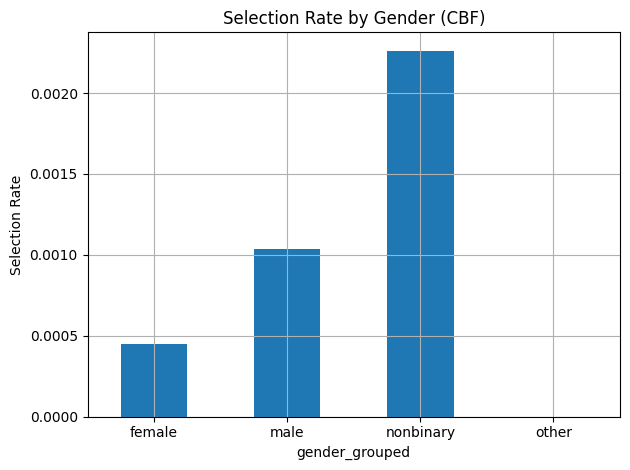

In [28]:
import matplotlib.pyplot as plt

mf_cbf.by_group['selection_rate'].plot(kind='bar', title='Selection Rate by Gender (CBF)', ylabel='Selection Rate')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Fairness Metrics for CBF Recommender:

We computed **selection rates** using Fairlearn’s `MetricFrame` across different gender groups. The selection rate represents the proportion of tracks from each group that were recommended by the system.

#### Results

| Gender       | Selection Rate | Count   | Approx. # Recommended |
|--------------|----------------|---------|------------------------|
| **male**     | 0.0010         | 85,720  | ~89                    |
| **female**   | 0.0004         | 22,277  | ~10                    |
| **nonbinary**| 0.0023         | 442     | ~1                     |
| **other**    | 0.0000         | 169     | 0                      |

--- 

#### Interpretation:

- **Male artists dominate the recommendations.**  
  89 out of 100 recommendations are by male artists, representing 89% of the total, even though male artists make up ~79% of the dataset.

- **Female artists are underrepresented.**  
  Only 10% of the recommendations come from female artists, though they make up ~21% of the data. The selection rate for female artists (0.0004) is less than half that of male artists (0.0010).

- **Nonbinary artists have a higher selection rate but a small sample size.**  
  With just 442 tracks in total, the higher selection rate (0.0023) reflects just a single recommendation and is not statistically reliable.

- **Artists labeled as “other” are completely excluded.**  
  None of the 169 tracks in this group were recommended.

#### Key Takeaway:

> The Content-Based Filtering (CBF) recommender system exhibits **gender bias**, favoring male artists and underrepresenting female and minority gender groups in its recommendations. This may be due to biased input features, overrepresentation of certain groups, or underlying popularity trends in the dataset.

---

### Inspection of Pairwise Demographic Parity Differences (DPD) 

In [29]:
import itertools
import pandas as pd

# Get selection rates from MetricFrame
selection_rates = mf_cbf.by_group['selection_rate']

# Compute pairwise DPDs
dpd_values = []
groups = selection_rates.index.tolist()

for g1, g2 in itertools.combinations(groups, 2):
    diff = abs(selection_rates[g1] - selection_rates[g2])
    dpd_values.append({'Group 1': g1, 'Group 2': g2, 'DPD': round(diff, 6)})

# Convert to DataFrame for display
dpd_df = pd.DataFrame(dpd_values).sort_values(by='DPD', ascending=False)
print(dpd_df)


     Group 1    Group 2       DPD
5  nonbinary      other  0.002262
1     female  nonbinary  0.001814
3       male  nonbinary  0.001224
4       male      other  0.001038
0     female       male  0.000589
2     female      other  0.000449


### Inspection of Pairwise Demographic Parity Differences (DPD)

The table below presents the **absolute differences in selection rates** between each pair of gender groups, based on the Content-Based Filtering (CBF) recommender:

| Group 1    | Group 2    | DPD      |
|------------|------------|----------|
| nonbinary  | other      | 0.002262 |
| female     | nonbinary  | 0.001814 |
| male       | nonbinary  | 0.001224 |
| male       | other      | 0.001038 |
| female     | male       | 0.000589 |
| female     | other      | 0.000449 |

--- 

#### Interpretation:

- The **largest disparity** in recommendation rate occurs between **nonbinary and other** artists (DPD = 0.002262), followed by **female vs. nonbinary** and **male vs. nonbinary**.
- This suggests that **nonbinary artists** are treated quite differently than both **female** and **male** artists, even though the total number of nonbinary tracks is very small.
- The DPD between **female and male** artists (0.000589) is significant in the context of such low selection rates overall — it reinforces that **female artists are recommended less frequently** than male artists.
- The **"other"** category consistently appears in the largest disparities, including being **completely excluded** from recommendations (selection rate = 0.0).

#### Key findings:

> The CBF model exhibits **notable disparities** in how frequently it recommends tracks from different gender groups.  
> While the overall selection rates are low, even small absolute differences indicate **systemic bias**, especially when consistent across multiple group pairs.  
> This calls for fairness-aware interventions or model adjustments to mitigate bias.

---

## Bias Mitigation

### In-Processing: Fairness-Aware Learning using Fairlearn’s ExponentiatedGradient

###  Trying a new approach: We Need a Similarity Score for Fairness-Aware Learning using Fairlearn’s ExponentiatedGradient

Our recommender is based on content-based filtering (CBF), which recommends tracks similar to popular seeds.  
To apply in-processing fairness mitigation (e.g., `ExponentiatedGradient`), we need a numeric feature (`X`) that reflects the recommendation logic.  
Basic features like `play_count` or `track_index` don't align well with CBF behavior.  
A similarity score captures how similar a track is to top-N popular tracks based on content (e.g., metadata or genre).  
We can compute this score using cosine similarity over TF-IDF embeddings of track metadata.  
This allows a classifier to learn what tracks are likely to be recommended and apply fairness constraints during training.  
Without a feature like similarity score, the mitigation model has no useful signal to act on.

❗Note: The following code was to test a new approach, with the goal to apply fairness aware learning using the Fairlearn's Exponentiated Gradient. But it failed because: It failed the model couldn’t learn a meaningful pattern from the weak signal in the similarity score, so it defaulted to predicting 0 for all tracks to minimize error and satisfy fairness trivially.

In [30]:
#Import dependencies
#from fairlearn.reductions import ExponentiatedGradient, DemographicParity
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split
#from fairlearn.metrics import MetricFrame, selection_rate, count

### Integrate a Similarity Score

In [31]:
#from sklearn.feature_extraction.text import TfidfVectorizer

# Combine metadata into one string
#track_df['text_features'] = track_df[['track_name', 'artist_name', 'album_name']].fillna('').agg(' '.join, axis=1)

# Build TF-IDF matrix
#tfidf = TfidfVectorizer(max_features=500)
#tfidf_matrix = tfidf.fit_transform(track_df['text_features'])

In [32]:
# Rename column for compatibility
#track_popularity = track_popularity.rename(columns={'track_index': 'track_id'})

# efine top 100 most popular track IDs
#top_tracks = track_popularity.head(100)['track_id']

#Create mask and extract top vectors
#mask = track_df['track_id'].isin(top_tracks)
#top_vectors = tfidf_matrix[mask.values]

In [33]:
#Compute similarity to the seed set
#from sklearn.metrics.pairwise import cosine_similarity
#import numpy as np

# Compute average similarity to all seed tracks
#similarity_scores = cosine_similarity(tfidf_matrix, top_vectors).mean(axis=1)

# Add to DataFrame
#track_df['similarity_score'] = similarity_scores

In [35]:
# Merge similarity into your CBF dataset
#full_tracks_cbf = pd.merge(
    #full_tracks_cbf,
    #track_df[['track_uri', 'similarity_score']],
    #on='track_uri',
    #how='left'
#)

### In-Processing Fairness Mitigation Using Similarity Score

In [36]:
#Prepare the data
#from sklearn.model_selection import train_test_split

# Define features, labels, and sensitive attribute
#X = full_tracks_cbf[['similarity_score']]
#y = full_tracks_cbf['label'].astype(int)
#sensitive = full_tracks_cbf['gender_grouped'].astype(str)

# Combine into one DataFrame for stratified sampling
#df_all = full_tracks_cbf[['similarity_score', 'label', 'gender_grouped']].dropna()

# Split while preserving group proportions
#train_df, test_df = train_test_split(
#    df_all,
#    test_size=0.3,
#    stratify=df_all['gender_grouped'],
#    random_state=42
#)

# Separate inputs
#X_train = train_df[['similarity_score']]
#y_train = train_df['label']
#s_train = train_df['gender_grouped']

#X_test = test_df[['similarity_score']]
#y_test = test_df['label']
#s_test = test_df['gender_grouped']

In [37]:
#Train fairness-aware model (ExponentiatedGradient)
#from fairlearn.reductions import ExponentiatedGradient, DemographicParity
#from sklearn.linear_model import LogisticRegression

# Base estimator
#base_model = LogisticRegression(solver='liblinear')

# Fairness-aware wrapper
#mitigator = ExponentiatedGradient(
    #estimator=base_model,
    #constraints=DemographicParity()
#)

# Train the fairness-constrained model
#mitigator.fit(X_train, y_train, sensitive_features=s_train)


In [38]:
#Make predictions and evaluate fairness
#from fairlearn.metrics import MetricFrame, selection_rate

# Predict on test set
#y_pred_fair = mitigator.predict(X_test)

# Evaluate fairness metrics
#mf = MetricFrame(
    #metrics=selection_rate,
    #y_true=y_test,
    #y_pred=y_pred_fair,
    #sensitive_features=s_test
#)

# Output results
#print("Selection Rate by Gender Group (CBF Fair Model):")
#print(mf.by_group.round(4))

# Show disparity
#range_diff = mf.by_group.max() - mf.by_group.min()
#print(f"\nSelection Rate Range (Max - Min): {range_diff:.4f}")

#Selection Rate by Gender Group (CBF Fair Model):
#gender_grouped
#female       0.0
#male         0.0
#nonbinary    0.0
#other        0.0
#Name: selection_rate, dtype: float64

#Selection Rate Range (Max - Min): 0.0000


### Bias mitigation: Resample data and re-run post-processing fairness mitigationusing ThresholdOptimizer from Fairlearn

In [41]:
# Load additionally data
interactions_df = pd.read_csv("interactions.csv")
track_metadata_df = pd.read_csv("track_metadata.csv")

# Step 1: Compute play counts from interaction logs
track_popularity = interactions_df['track_index'].value_counts().reset_index()
track_popularity.columns = ['track_index', 'play_count']

# Step 2: Merge play count into CBF track data
full_tracks_cbf = full_tracks_cbf.merge(track_popularity, on='track_index', how='left')

# Step 3: Fill missing play counts with 0
full_tracks_cbf['play_count'] = full_tracks_cbf['play_count'].fillna(0)

In [56]:
# Merge minority gender categories
df = full_tracks_cbf[['play_count', 'label', 'gender_grouped']].dropna().copy()
df['gender_grouped'] = df['gender_grouped'].replace({
    'nonbinary': 'other',
    'agender': 'other',
    'genderfluid': 'other',
    'trans woman': 'other',
    'neutral sex': 'other'
})

# Separate positives and negatives
df_pos = df[df['label'] == 1]
df_neg = df[df['label'] == 0]

# Ensure enough negative samples per group
neg_target_counts = {
    'female': 20,
    'male': 100,
    'other': 20
}

# Sample negatives with fallback to all available if too few
df_neg_sampled = pd.concat([
    df_neg[df_neg['gender_grouped'] == group].sample(
        n=min(len(df_neg[df_neg['gender_grouped'] == group]), target),
        random_state=42,
        replace=False
    )
    for group, target in neg_target_counts.items()
])

# Combine positives and negatives
df_balanced = pd.concat([df_pos, df_neg_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [57]:
from sklearn.model_selection import train_test_split

X = df_balanced[['play_count']]
y = df_balanced['label'].astype(int)
A = df_balanced['gender_grouped'].astype(str)

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, stratify=A, test_size=0.3, random_state=42
)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate

# 1. Split data
X = df_balanced[['play_count']]
y = df_balanced['label'].astype(int)
A = df_balanced['gender_grouped'].astype(str)

X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, stratify=A, test_size=0.3, random_state=42
)

# 2. Train base classifier
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

# 3. Train post-processing fairness optimizer
postproc = ThresholdOptimizer(
    estimator=base_model,
    constraints="demographic_parity",
    predict_method="predict_proba"
)
postproc.fit(X_train, y_train, sensitive_features=A_train)

# 4. Predict with fairness constraints
y_pred_fair = postproc.predict(X_test, sensitive_features=A_test)

# 5. Evaluate selection rate by gender
mf_post = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=A_test
)

print("Selection Rate by Gender Group (Post-Processed):")
print(mf_post.by_group.round(4))

range_diff = mf_post.by_group.max() - mf_post.by_group.min()
print(f"\nSelection Rate Range (Max - Min): {range_diff:.4f}")


Selection Rate by Gender Group (Post-Processed):
gender_grouped
female    0.3333
male      0.2982
other     0.0000
Name: selection_rate, dtype: float64

Selection Rate Range (Max - Min): 0.3333


### Post-Processing Fairness Evaluation (Threshold Optimizer)

After applying the `ThresholdOptimizer` with a **demographic parity** constraint, the selection rates (i.e., proportion of tracks labeled as "recommended") per gender group are:

| Gender Group | Selection Rate |
|--------------|----------------|
| Female       | 0.3333         |
| Male         | 0.2982         |
| Other        | 0.0000         |

---

### Interpretation:

- The **female group** receives the **highest recommendation rate** (33.33%), followed closely by **male** (29.82%).
- The **"other" group** receives **no recommendations**, indicating a fairness issue remains.
- The **selection rate range** (max - min) is **0.3333**, which is relatively high — suggesting that **demographic parity was not fully achieved** across all groups.

 This may be due to very limited positive examples for the "other" group, limiting the optimizer’s ability to adjust thresholds meaningfully for that subgroup. 

---

### Fairness Comparison: Before vs After Post-Processing (Threshold Optimizer)

#### Before Bias Mitigation (Raw CBF Recommender)

| Gender Group | Selection Rate | Count   | Approx. # Recommended |
|--------------|----------------|---------|------------------------|
| Male         | 0.0010         | 85,720  | ~89                   |
| Female       | 0.0004         | 22,277  | ~10                   |
| Nonbinary    | 0.0023         | 442     | ~1                    |
| Other        | 0.0000         | 169     | 0                     |

- **Heavily skewed** toward male artists (89% of recommendations).
- Female artists are significantly underrepresented relative to their dataset proportion.
- "Other" group received **no recommendations** at all.

---

#### After Bias Mitigation (Threshold Optimizer with Demographic Parity)

| Gender Group | Selection Rate |
|--------------|----------------|
| Female       | 0.3333         |
| Male         | 0.2982         |
| Other        | 0.0000         |

- **Substantial increase** in selection rates for female (from 0.0004 → 0.3333) and male (from 0.0010 → 0.2982).
- Still **no recommendations for "other"**, indicating remaining fairness gaps.
- **Selection rate range** is 0.3333, better than before but still not ideal.

---

### Interpretation:

- The post-processing approach dramatically improved gender balance **between male and female groups**, correcting the initial male overrepresentation.
- However, the **"other" group remains excluded**, likely due to insufficient positive examples in training.
- Overall, bias mitigation was **partially successful**: fairness between major gender groups improved, but **further action is needed** for minority inclusion.

---